# This notebook explores the use of an RNN model for predicting beaching locations with the Asia watershed

In [ ]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/dat1/openonic/Drifters'

In [2]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.8 MB/s eta 0:00:00


In [3]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tqdm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 2.5)

In [4]:
# load data
#Asia = pd.read_csv('drifter_data/cluster_16_data.csv').drop(columns = 'HDBSCAN')
# colab
Asia = pd.read_csv('cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


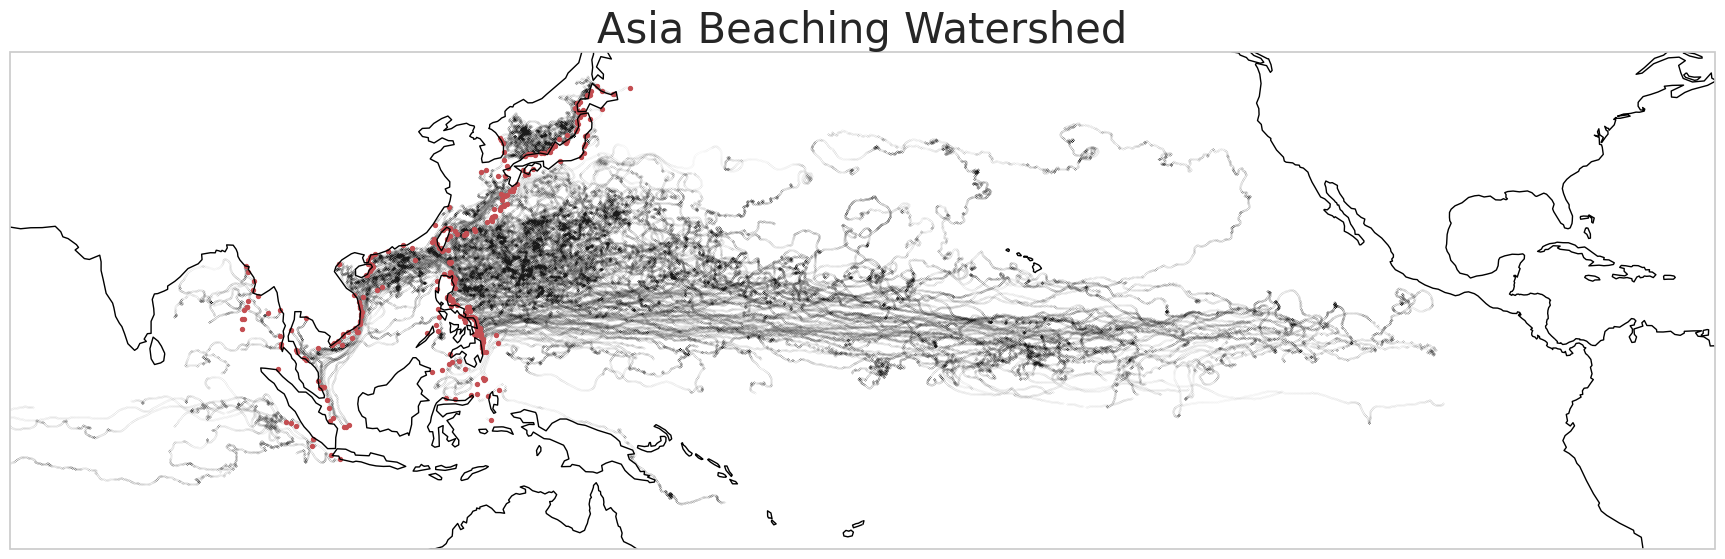

In [5]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by:
## 1. Applying a coordinate transform and normalizing
## 2. Converting into tensors
## 3. Splitting into train, test, validation, and target
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a sphere (we make the assumption the Earth is a perfect sphere, it isn't, but this shouldn't impact our results in any significant way). The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [6]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):

    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)

    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r)
    z = np.sin(lats_r)

    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))

    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)

    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

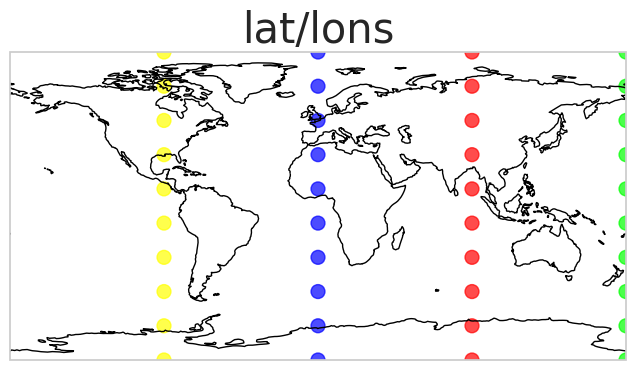

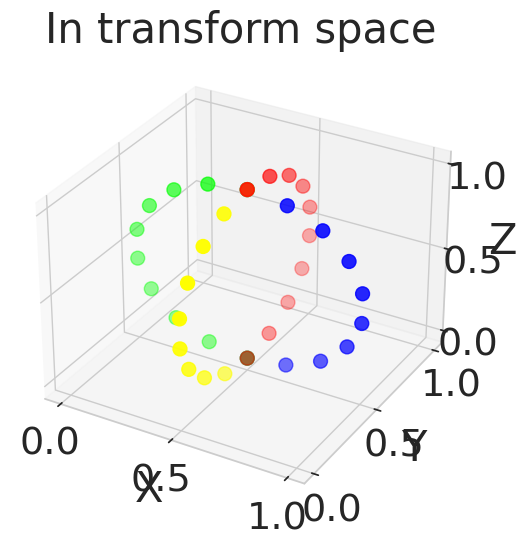

In [7]:
# now we apply this transform to some toy lat/lons:
toy_latitudes_1 = np.array(np.linspace(-90,90,10))
toy_longitudes_1 = np.array(np.ones(10) * 90)

toy_latitudes_2 = np.array(np.linspace(-90,90,10))
toy_longitudes_2 = np.array(np.ones(10) * 180)

toy_latitudes_3 = np.array(np.linspace(-90,90,10))
toy_longitudes_3 = np.array(np.zeros(10))

toy_latitudes_4 = np.array(np.linspace(-90,90,10))
toy_longitudes_4 = np.array(np.ones(10) * -90)


toy_latitudes = np.concatenate((toy_latitudes_1, toy_latitudes_2, toy_latitudes_3, toy_latitudes_4))
toy_longitudes = np.concatenate((toy_longitudes_1, toy_longitudes_2, toy_longitudes_3, toy_longitudes_4))

# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
point_size = 100
color1 = np.array([[255, 0, 0]] * 10) / 255.0  # Red
color2 = np.array([[0, 255, 0]] * 10) / 255.0  # Green
color3 = np.array([[0, 0, 255]] * 10) / 255.0  # Blue
color4 = np.array([[255, 255, 0]] * 10) / 255.0  # Yellow
colors = np.concatenate((color1, color2, color3, color4))
toy_scatter_red =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c=colors,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7)

plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100, c= colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [8]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()
# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

# initialize MinMaxScaler for time_to_beach
#time_to_beach_scaler = MinMaxScaler()
#Asia_time_to_beach_norm = time_to_beach_scaler.fit_transform(np.array(Asia['time_to_beach']).reshape(-1,1))

Asia_norm = Asia.drop(columns = ['lat', 'lon','time_to_beach']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

In [34]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id'
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index()

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR REDUCING MODEL SIZE-------------------------------------------------------------------
#Asia_by_traj = Asia_by_traj[0:12]

In [35]:
# helper function for trajectory splitting
def sequence_splitting(feature, dataframe, sequence_length):

    # initialize output
    sequences = []

    # iterate through each trajectory
    for trajectory in dataframe[feature]:

        trajectory = np.array(trajectory) # convert to numpy array for faster processing

        # calculate the starting index to ensure the last sequence fits exactly
        # i.e, remove the first coords such that the length of the trajectory is divisible by the sequence length
        start_idx = len(trajectory) % sequence_length

        # split the trajectory into non-overlapping sequences of length sequence_length
        for i in range(start_idx, len(trajectory), sequence_length):
            if i + sequence_length <= len(trajectory):
                sequences.append(trajectory[i:i+sequence_length])

    return sequences

# helper function for src and tgt splitting
def src_tgt_splitting(feature, percent_src, sequence_length):

    # determine the length of src sequences
    src_length = int(sequence_length * percent_src / 100)

    # assign the first indices to src by percent_src
    src = [sequence[:src_length] for sequence in feature]

    # assign the remaining indices to tgt
    tgt = [sequence[src_length:] for sequence in feature]

    return (src, tgt)

# we define a function to split trajectories into sub-sequences and further split into src and tgt
# note that sequence_length should be equal to or less than min length of trajectories
def split_trajectories(dataframe, sequence_length, percent_src):

    # split x,y,z features of each trajectory into sequences of length sequence_length
    x = sequence_splitting('x', dataframe, sequence_length)
    y = sequence_splitting('y', dataframe, sequence_length)
    z = sequence_splitting('z', dataframe, sequence_length)

    # split into src and tgt by percent_src
    x_src_tgt = src_tgt_splitting(x, percent_src, sequence_length)
    y_src_tgt = src_tgt_splitting(y, percent_src, sequence_length)
    z_src_tgt = src_tgt_splitting(z, percent_src, sequence_length)

    return x_src_tgt, y_src_tgt, z_src_tgt

# perform the split into sequences of length 1000, then split sequences into 80% src
sequence_length = 1000
percent_src = 50 # between 0 and 100
x_src_tgt, y_src_tgt, z_src_tgt = split_trajectories(Asia_by_traj, sequence_length, percent_src)

Text(0.5, 0.92, 'Sequences in Transform Space divided into Black SRC and Red TGT')

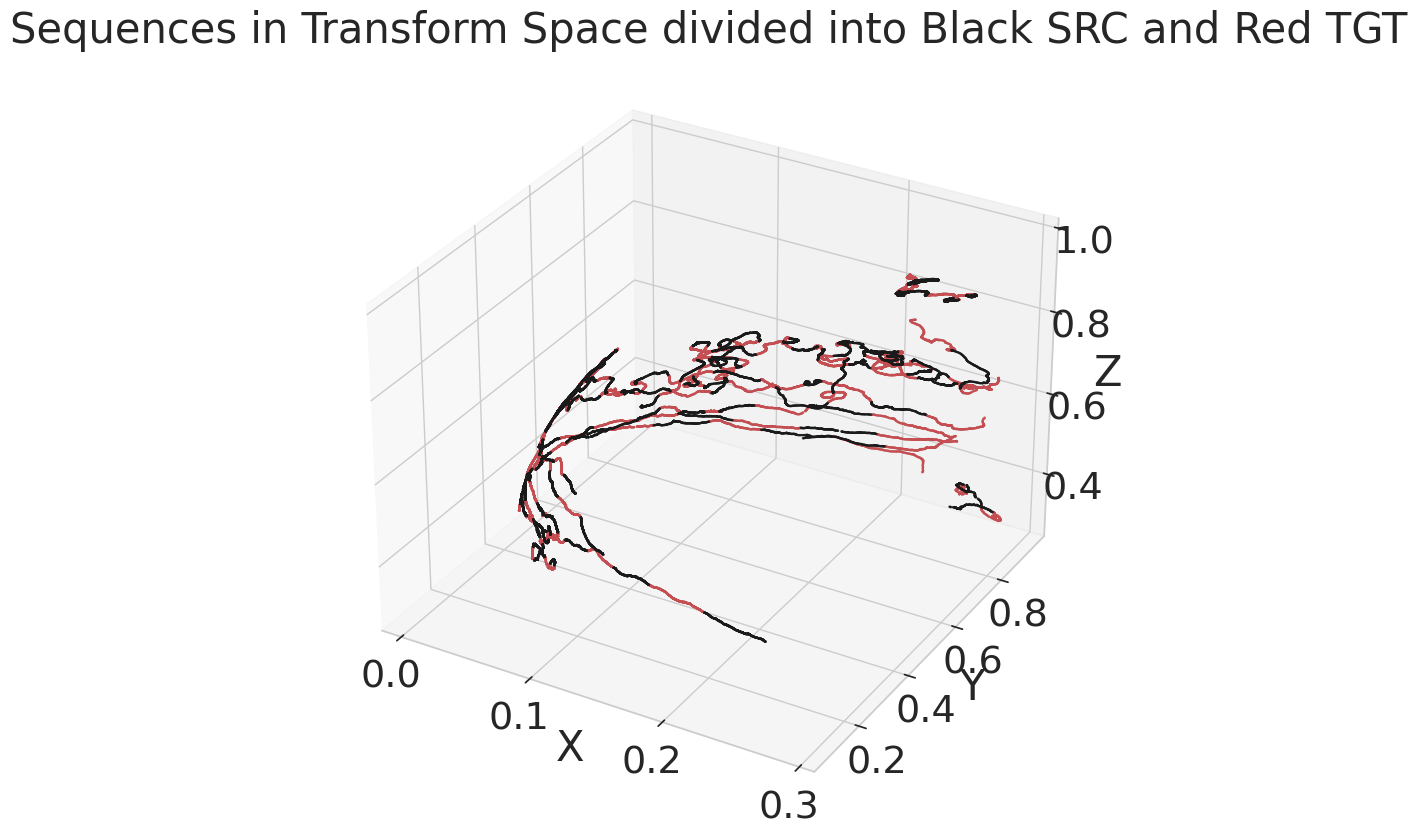

In [36]:
# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_src_tgt[0][0:100], y_src_tgt[0][0:100],
           z_src_tgt[0][0:100], s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(x_src_tgt[1][0:100], y_src_tgt[1][0:100],
           z_src_tgt[1][0:100], s = 0.5, color ='r')


plt.title('Sequences in Transform Space divided into Black SRC and Red TGT')

In [37]:
# reduce the number of data by taking windows and averaging
def window_avg(data, window_size):
    # reshape the data to facilitate window averaging
    reshaped_data = data[:len(data)//window_size * window_size].reshape(-1, window_size)

    # calculate the mean along the last axis
    averaged_data = np.mean(reshaped_data, axis=1)

    return averaged_data

# get data from dataframe and apply reduction
window_size = 20 # set window_size

# apply window averaging to src
x_src = [window_avg(sequence, window_size) for sequence in x_src_tgt[0]]
y_src = [window_avg(sequence, window_size) for sequence in y_src_tgt[0]]
z_src = [window_avg(sequence, window_size) for sequence in z_src_tgt[0]]

# apply window averaging to tgt
x_tgt = [window_avg(sequence, window_size) for sequence in x_src_tgt[1]]
y_tgt = [window_avg(sequence, window_size) for sequence in y_src_tgt[1]]
z_tgt = [window_avg(sequence, window_size) for sequence in z_src_tgt[1]]

# combine src x,y,z together, stack, and transpose into shape [sequences, length, x y z]
all_src = np.transpose(np.stack([x_src, y_src, z_src], axis = 0), (1,2,0))
all_tgt = np.transpose(np.stack([x_tgt, y_tgt, z_tgt], axis = 0), (1,2,0))

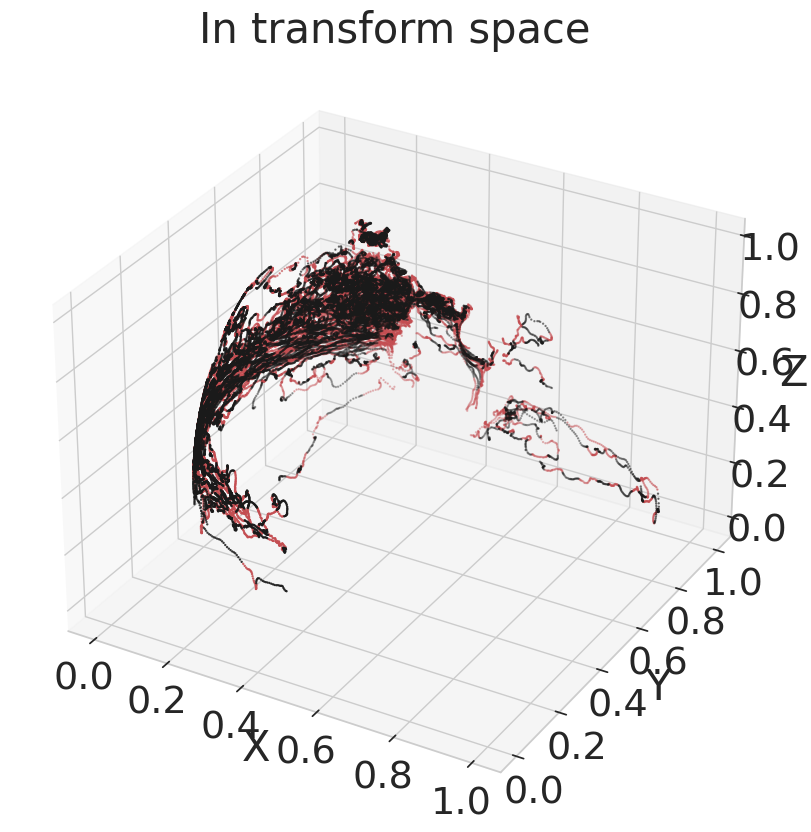

In [38]:
# let's take a look at the output of coordinate transformation, normalization, sequencing, and splitting into src and tgt:
# x
Asia_src_x = all_src[:,:,0]
Asia_tgt_x = all_tgt[:,:,0]

# y
Asia_src_y = all_src[:,:,1]
Asia_tgt_y = all_tgt[:,:,1]

# z
Asia_src_z = all_src[:,:,2]
Asia_tgt_z = all_tgt[:,:,2]

# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_src_x, Asia_src_y,
           Asia_src_z, s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(Asia_tgt_x, Asia_tgt_y,
           Asia_tgt_z, s = 0.5, color ='r')
plt.title('In transform space')

plt.show()

In [39]:
np.shape(all_src)

(1241, 25, 3)

In [40]:
# split data and input lengths into training and remaining (for validation and testing)
train_src, remaining_src, train_tgt, remaining_tgt = train_test_split(
    all_src, all_tgt, train_size = 1201, random_state = 42)

# split the remaining data and input lengths into validation and test sets
val_src, test_src, val_tgt, test_tgt = train_test_split(
    remaining_src, remaining_tgt, test_size = 20, random_state = 42)

# collate (combine src and tgt into single tensor)
# train
#train_src_collated, train_tgt_collated = collate_fn(train_src), collate_fn(train_tgt)

# val
#val_src_collated, val_tgt_collated = collate_fn(val_src), collate_fn(val_tgt)

# test
#test_src_collated, test_tgt_collated = collate_fn(test_src), collate_fn(test_tgt)

# save as train, val, test of shape:[trajectories (batch), src or tgt, length (of trajectories), x y z (coordinate dimensions)]
#training_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(train_src, train_tgt)]
#validation_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(val_src, val_tgt)]
#testing_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(test_src, test_tgt)]


training_data_src = torch.tensor(train_src, dtype = torch.float32).cuda()
training_data_tgt = torch.tensor(train_tgt, dtype = torch.float32).cuda()

validation_data_src = torch.tensor(val_src, dtype = torch.float32).cuda()
validation_data_tgt = torch.tensor(val_tgt, dtype = torch.float32).cuda()

testing_data_src = torch.tensor(test_src, dtype = torch.float32).cuda()
testing_data_tgt = torch.tensor(test_tgt, dtype = torch.float32).cuda()

### Define vanilla RNN model and set hyperparameters

In [41]:
# let's define our vanilla RNN model:
class drifter_vanilla_RNN(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, nonlinearity, output_size):

        super(drifter_vanilla_RNN, self).__init__()

        # define rnn cell with nonlinearity
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                                num_layers = num_layers, nonlinearity = nonlinearity) # maybe try LSTM/GRU later

        # define fully connected layer to predict next part of target sequence
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, padded_input, hidden_state):
        # pack padded sequence
        #packed_input = rnn_utils.pack_padded_sequence(padded_input, input_lengths, batch_first=True, enforce_sorted=False)

        # get output and hidden state through rnn
        output, hidden_state = self.rnn(padded_input, hidden_state)

        # unpack output
        #output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # extract the output from the last time step for each sequence (lat/lon of beaching)
        #final_lat_lon = output[:, -1, :]

        # predict the final beaching coordinates
        output = self.fc(output)

        return output, hidden_state.detach()

In [57]:
# define hyperparameters

# Fix random seed
torch.manual_seed(42)

# Define RNN network:
rnn = drifter_vanilla_RNN(input_size = 3, hidden_size = 1028, num_layers = 2,
              output_size = 3, nonlinearity = 'relu').cuda()

# Define learning rate, epochs, and batchsize
lr = 0.0001
epochs = 100
batchsize = 1

# define loss function
loss_func = torch.nn.MSELoss() # for regression

# use Adam optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr = lr)

# track training loss and validation loss
train_loss_list = []
val_loss_list = []


# split training data and lengths into batches
train_data_batch = torch.split(training_data_src, batchsize)

# split training targets into batches
train_targets_batch = torch.split(training_data_tgt, batchsize)

# length of train_batches_features = total number of batches in the training set
batch_split_num = len(train_data_batch)

## Now, we train the model

In [58]:
# Let's train our model now (tqdm creates nice progress bar)
for epoch in tqdm.trange(epochs):

    # iterate through each batch
    for batch in range(batch_split_num):


        # initialize hidden_state for each epoch:
        hidden_state = None

        #separate learning for each epoch by initializing optimzer each epoch
        optimizer.zero_grad()

        # pass training inputs through model to get outputs
        train_outputs, hidden_state = rnn(train_data_batch[batch].float(), hidden_state)

        # compute loss
        train_loss = loss_func(train_outputs, train_targets_batch[batch])#.to(device))

        # determine changes needed for each weight/bias for next epoch
        train_loss.backward()

        # apply changes to weights/biases
        optimizer.step()

    # print training loss each epoch
    print('training loss: '+ str(train_loss.item()))

    # save loss for each epoch
    train_loss_list.append(train_loss.item())

    # compute validation loss for each epoch:
    # validation tests model against non-training data to ensure model isn't overfitting to training data
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose#

        # initialize hidden_state for each epoch:
        hidden_state = None

        # apply model to validation data
        val_outputs, val_hidden_state = rnn(validation_data_src.float(), hidden_state)#.to(device))

        # compute validation loss
        val_loss = loss_func(val_outputs, validation_data_tgt)

        # save validation loss for each epoch
        val_loss_list.append(val_loss.item())

  1%|          | 1/100 [00:02<03:32,  2.15s/it]

training loss: 0.014131979085505009


  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

training loss: 0.003199483035132289


  3%|▎         | 3/100 [00:07<03:50,  2.38s/it]

training loss: 0.0023867131676524878


  4%|▍         | 4/100 [00:09<03:37,  2.27s/it]

training loss: 0.002181962365284562


  5%|▌         | 5/100 [00:11<03:30,  2.21s/it]

training loss: 0.0020768356043845415


  6%|▌         | 6/100 [00:13<03:26,  2.19s/it]

training loss: 0.0020082942210137844


  7%|▋         | 7/100 [00:15<03:24,  2.19s/it]

training loss: 0.0020099510438740253


  8%|▊         | 8/100 [00:18<03:37,  2.37s/it]

training loss: 0.0018991591641679406


  9%|▉         | 9/100 [00:20<03:29,  2.31s/it]

training loss: 0.001822527265176177


 10%|█         | 10/100 [00:22<03:23,  2.26s/it]

training loss: 0.0017527577001601458


 11%|█         | 11/100 [00:24<03:18,  2.23s/it]

training loss: 0.00161748006939888


 12%|█▏        | 12/100 [00:27<03:13,  2.19s/it]

training loss: 0.00169541803188622


 13%|█▎        | 13/100 [00:29<03:12,  2.22s/it]

training loss: 0.0016933144070208073


 14%|█▍        | 14/100 [00:31<03:23,  2.37s/it]

training loss: 0.001684081624262035


 15%|█▌        | 15/100 [00:34<03:14,  2.29s/it]

training loss: 0.0017144002486020327


 16%|█▌        | 16/100 [00:36<03:09,  2.26s/it]

training loss: 0.0016347526106983423


 17%|█▋        | 17/100 [00:38<03:04,  2.22s/it]

training loss: 0.0016427686205133796


 18%|█▊        | 18/100 [00:40<03:00,  2.20s/it]

training loss: 0.0016286445315927267


 19%|█▉        | 19/100 [00:42<03:02,  2.25s/it]

training loss: 0.001641616108827293


 20%|██        | 20/100 [00:45<03:09,  2.37s/it]

training loss: 0.0016718789702281356


 21%|██        | 21/100 [00:47<03:00,  2.29s/it]

training loss: 0.0016341061564162374


 22%|██▏       | 22/100 [00:49<02:53,  2.23s/it]

training loss: 0.001682185335084796


 23%|██▎       | 23/100 [00:51<02:48,  2.19s/it]

training loss: 0.0016997326165437698


 24%|██▍       | 24/100 [00:53<02:44,  2.16s/it]

training loss: 0.0017278899904340506


 25%|██▌       | 25/100 [00:56<02:45,  2.21s/it]

training loss: 0.0017244978807866573


 26%|██▌       | 26/100 [00:58<02:53,  2.35s/it]

training loss: 0.0017317513702437282


 27%|██▋       | 27/100 [01:01<02:46,  2.27s/it]

training loss: 0.0017015290213748813


 28%|██▊       | 28/100 [01:03<02:40,  2.22s/it]

training loss: 0.0016934697050601244


 29%|██▉       | 29/100 [01:05<02:35,  2.19s/it]

training loss: 0.001757670077495277


 30%|███       | 30/100 [01:07<02:31,  2.17s/it]

training loss: 0.0017894242191687226


 31%|███       | 31/100 [01:09<02:33,  2.23s/it]

training loss: 0.0017013514880090952


 32%|███▏      | 32/100 [01:12<02:38,  2.33s/it]

training loss: 0.0017819401109591126


 33%|███▎      | 33/100 [01:14<02:32,  2.28s/it]

training loss: 0.0017715278081595898


 34%|███▍      | 34/100 [01:17<02:44,  2.49s/it]

training loss: 0.001748812384903431


 35%|███▌      | 35/100 [01:19<02:41,  2.48s/it]

training loss: 0.001775445998646319


 36%|███▌      | 36/100 [01:22<02:35,  2.42s/it]

training loss: 0.0017863870598375797


 37%|███▋      | 37/100 [01:24<02:38,  2.51s/it]

training loss: 0.0017930513713508844


 38%|███▊      | 38/100 [01:27<02:27,  2.39s/it]

training loss: 0.001801690668798983


 39%|███▉      | 39/100 [01:29<02:20,  2.30s/it]

training loss: 0.0017949255416169763


 40%|████      | 40/100 [01:31<02:14,  2.24s/it]

training loss: 0.0017877003410831094


 41%|████      | 41/100 [01:33<02:09,  2.20s/it]

training loss: 0.0017966650193557143


 42%|████▏     | 42/100 [01:35<02:09,  2.24s/it]

training loss: 0.0018160578329116106


 43%|████▎     | 43/100 [01:38<02:13,  2.34s/it]

training loss: 0.0017918910598382354


 44%|████▍     | 44/100 [01:40<02:06,  2.27s/it]

training loss: 0.0017857758793979883


 45%|████▌     | 45/100 [01:42<02:02,  2.22s/it]

training loss: 0.001785348285920918


 46%|████▌     | 46/100 [01:44<01:58,  2.20s/it]

training loss: 0.0017989244079217315


 47%|████▋     | 47/100 [01:46<01:55,  2.18s/it]

training loss: 0.0017595681129023433


 48%|████▊     | 48/100 [01:49<01:58,  2.28s/it]

training loss: 0.0017483512638136744


 49%|████▉     | 49/100 [01:51<01:59,  2.34s/it]

training loss: 0.0017731433035805821


 50%|█████     | 50/100 [01:53<01:53,  2.27s/it]

training loss: 0.0017773685976862907


 51%|█████     | 51/100 [01:55<01:48,  2.22s/it]

training loss: 0.0017888505244627595


 52%|█████▏    | 52/100 [01:58<01:45,  2.19s/it]

training loss: 0.0017529360484331846


 53%|█████▎    | 53/100 [02:00<01:41,  2.16s/it]

training loss: 0.0017465405398979783


 54%|█████▍    | 54/100 [02:02<01:44,  2.27s/it]

training loss: 0.0018164992798119783


 55%|█████▌    | 55/100 [02:05<01:44,  2.33s/it]

training loss: 0.0018353186314925551


 56%|█████▌    | 56/100 [02:07<01:39,  2.27s/it]

training loss: 0.001860208110883832


 57%|█████▋    | 57/100 [02:09<01:35,  2.21s/it]

training loss: 0.0018804696155712008


 58%|█████▊    | 58/100 [02:11<01:31,  2.18s/it]

training loss: 0.001879598363302648


 59%|█████▉    | 59/100 [02:13<01:28,  2.17s/it]

training loss: 0.0018932020757347345


 60%|██████    | 60/100 [02:16<01:32,  2.31s/it]

training loss: 0.0019149164436385036


 61%|██████    | 61/100 [02:18<01:31,  2.34s/it]

training loss: 0.0019419072195887566


 62%|██████▏   | 62/100 [02:20<01:27,  2.29s/it]

training loss: 0.0019400914898142219


 63%|██████▎   | 63/100 [02:23<01:23,  2.26s/it]

training loss: 0.0019460744224488735


 64%|██████▍   | 64/100 [02:25<01:20,  2.23s/it]

training loss: 0.0019680913537740707


 65%|██████▌   | 65/100 [02:27<01:16,  2.20s/it]

training loss: 0.001958934124559164


 66%|██████▌   | 66/100 [02:30<01:20,  2.37s/it]

training loss: 0.001994416117668152


 67%|██████▋   | 67/100 [02:32<01:16,  2.30s/it]

training loss: 0.0019662778358906507


 68%|██████▊   | 68/100 [02:34<01:11,  2.25s/it]

training loss: 0.0019743952434509993


 69%|██████▉   | 69/100 [02:36<01:07,  2.19s/it]

training loss: 0.002010689117014408


 70%|███████   | 70/100 [02:38<01:04,  2.17s/it]

training loss: 0.002023769076913595


 71%|███████   | 71/100 [02:40<01:03,  2.19s/it]

training loss: 0.002013477962464094


 72%|███████▏  | 72/100 [02:43<01:05,  2.35s/it]

training loss: 0.0020082048140466213


 73%|███████▎  | 73/100 [02:45<01:01,  2.29s/it]

training loss: 0.002007449045777321


 74%|███████▍  | 74/100 [02:47<00:58,  2.25s/it]

training loss: 0.0020174833480268717


 75%|███████▌  | 75/100 [02:49<00:55,  2.21s/it]

training loss: 0.002020115964114666


 76%|███████▌  | 76/100 [02:52<00:52,  2.18s/it]

training loss: 0.00205265823751688


 77%|███████▋  | 77/100 [02:54<00:50,  2.21s/it]

training loss: 0.0020524775609374046


 78%|███████▊  | 78/100 [02:56<00:51,  2.36s/it]

training loss: 0.0020614832174032927


 79%|███████▉  | 79/100 [02:59<00:47,  2.28s/it]

training loss: 0.002091845963150263


 80%|████████  | 80/100 [03:01<00:44,  2.23s/it]

training loss: 0.002084696665406227


 81%|████████  | 81/100 [03:03<00:41,  2.20s/it]

training loss: 0.002111508045345545


 82%|████████▏ | 82/100 [03:05<00:39,  2.18s/it]

training loss: 0.002100595273077488


 83%|████████▎ | 83/100 [03:07<00:37,  2.22s/it]

training loss: 0.002136971103027463


 84%|████████▍ | 84/100 [03:10<00:37,  2.36s/it]

training loss: 0.0021582311019301414


 85%|████████▌ | 85/100 [03:12<00:34,  2.28s/it]

training loss: 0.002188430866226554


 86%|████████▌ | 86/100 [03:14<00:31,  2.23s/it]

training loss: 0.002144963014870882


 87%|████████▋ | 87/100 [03:16<00:28,  2.21s/it]

training loss: 0.002193970838561654


 88%|████████▊ | 88/100 [03:18<00:26,  2.18s/it]

training loss: 0.0021755932830274105


 89%|████████▉ | 89/100 [03:21<00:24,  2.23s/it]

training loss: 0.0021913163363933563


 90%|█████████ | 90/100 [03:23<00:23,  2.35s/it]

training loss: 0.0021971138194203377


 91%|█████████ | 91/100 [03:26<00:20,  2.29s/it]

training loss: 0.002226406941190362


 92%|█████████▏| 92/100 [03:28<00:17,  2.24s/it]

training loss: 0.0022183600813150406


 93%|█████████▎| 93/100 [03:30<00:15,  2.20s/it]

training loss: 0.0022579748183488846


 94%|█████████▍| 94/100 [03:32<00:12,  2.17s/it]

training loss: 0.0022402473259717226


 95%|█████████▌| 95/100 [03:34<00:11,  2.24s/it]

training loss: 0.0022514911834150553


 96%|█████████▌| 96/100 [03:37<00:09,  2.33s/it]

training loss: 0.0022318840492516756


 97%|█████████▋| 97/100 [03:39<00:06,  2.26s/it]

training loss: 0.0022625739220529795


 98%|█████████▊| 98/100 [03:41<00:04,  2.22s/it]

training loss: 0.0022246618755161762


 99%|█████████▉| 99/100 [03:43<00:02,  2.19s/it]

training loss: 0.002241945592686534


100%|██████████| 100/100 [03:45<00:00,  2.26s/it]

training loss: 0.002236258937045932


final training loss: 0.002236258937045932
final validation loss: 0.0006820351118221879


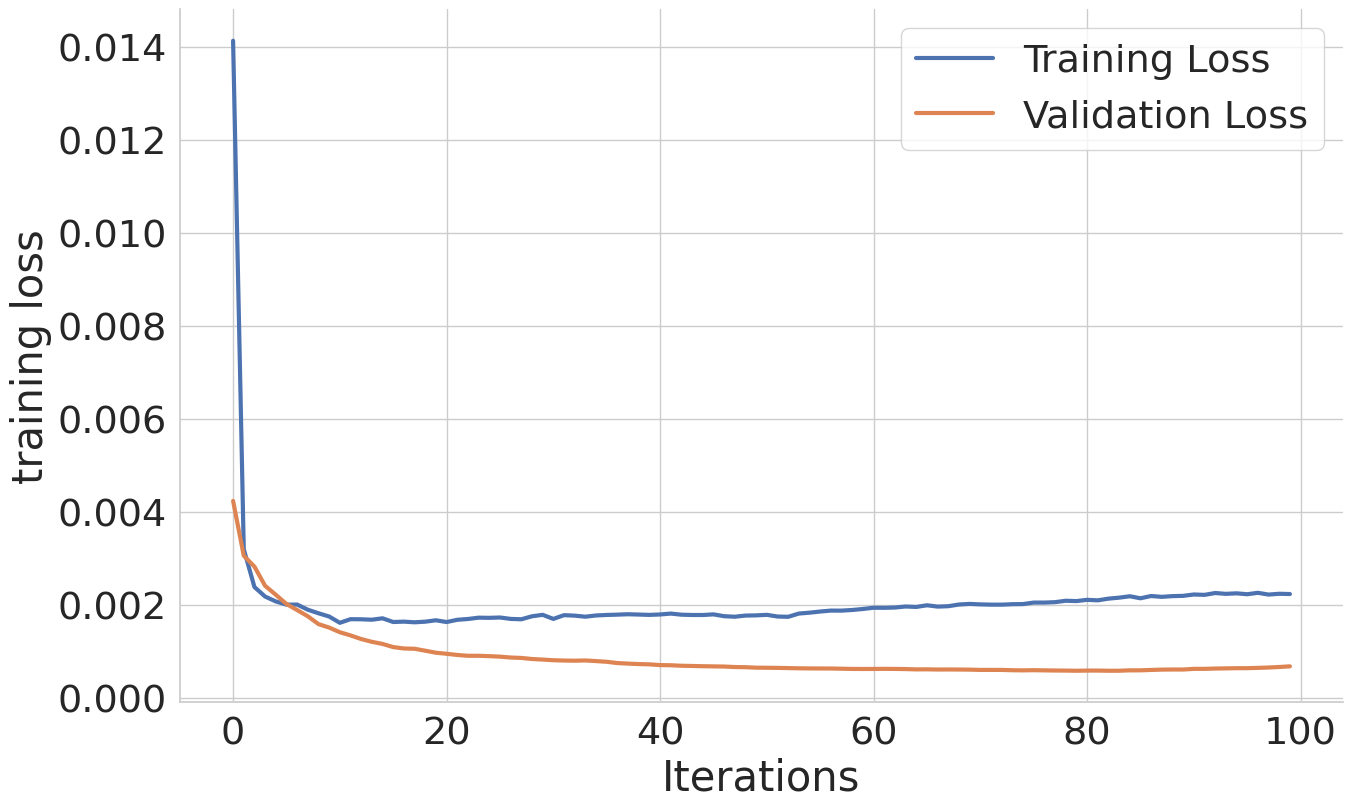

In [59]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(val_loss_list, linewidth = 3, label = 'Validation Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

## let's test our model with our test data now!

In [60]:
# activate no_grad() since we aren't performing backprop: testing not training
with torch.no_grad():

    # initialize hidden state for the encoder:
    hidden_state = None

    # pass training inputs through model to get outputs
    test_outputs, hidden_state = rnn(testing_data_src.float(), hidden_state)

    # compute loss
    test_loss = loss_func(test_outputs, testing_data_tgt)
print(test_loss.item())

0.001261513913050294


### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [61]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):

    lon_list = []
    lat_list = []
    for sequence in model_outputs:
        for coord in sequence:
            # convert from tensor to list
            coord_list = coord.tolist()

            # undo MinMaxScaler normalization
            coord_list_denorm = coord_scaler.inverse_transform(np.array(coord_list).reshape(-1, 3)).squeeze()

            x = coord_list_denorm[0]#[coord[0] for coord in coord_list_denorm]
            y = coord_list_denorm[1]#[coord[1] for coord in coord_list_denorm]
            z = coord_list_denorm[2]#[coord[2] for coord in coord_list_denorm]


            lons = np.degrees(np.arctan2(y, x))
            lats = np.degrees(np.arcsin(z))

            lon_list.append(lons)
            lat_list.append(lats)
    #print(lon_list)

    return lat_list, lon_list

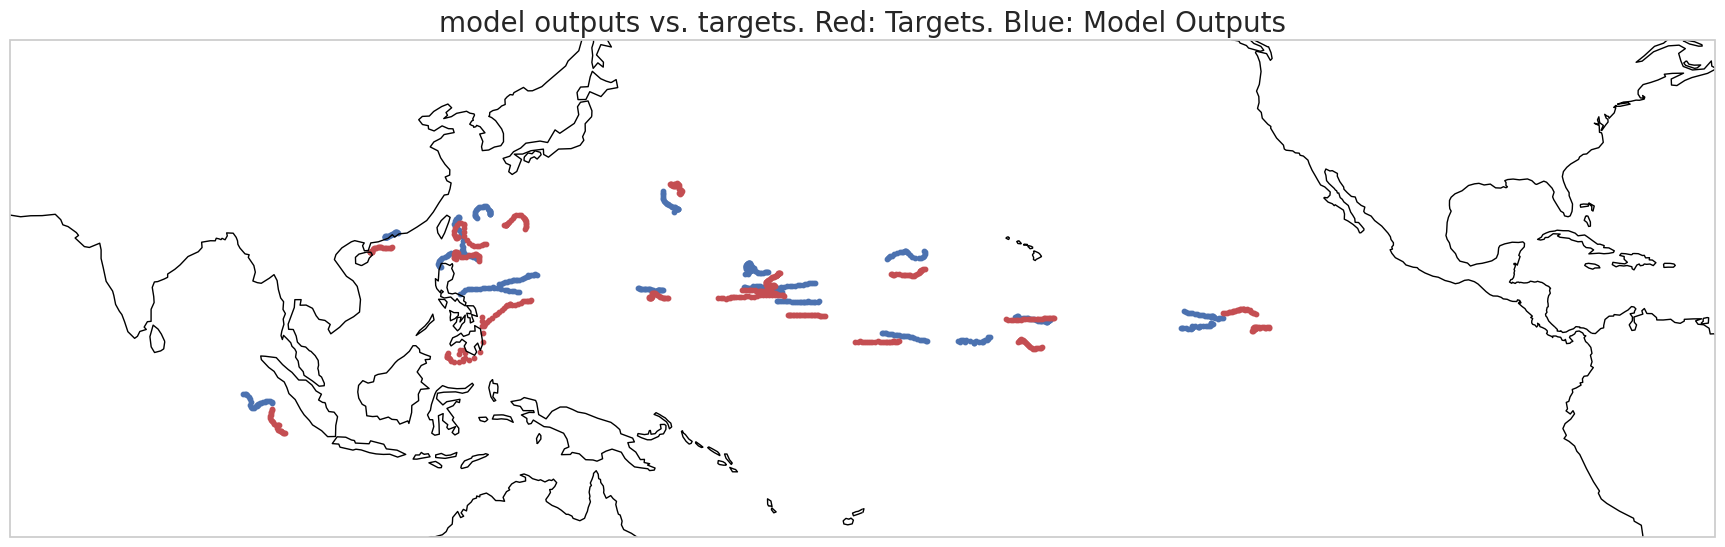

In [62]:
# convert x,y,z normalized outputs to denormalized lat/lon coords
lat_outputs, lon_outputs = inverse_coord_transform_normalize(test_outputs)

# convert x,y,z normalized targets to denormalized lat/lon coords
lat_targets, lon_targets = inverse_coord_transform_normalize(testing_data_tgt)

# plot model outputs vs. targets
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 10

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets. Red: Targets. Blue: Model Outputs', fontsize = 20)
plt.show()

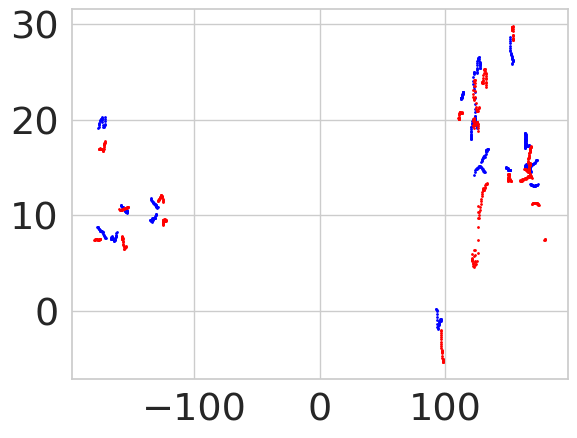

In [63]:
plt.scatter(lon_outputs, lat_outputs, s = 1, c = 'blue')
plt.scatter(lon_targets, lat_targets,s = 1, c = 'red')